In [22]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import os

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [27]:
# load dataset
cwd = os.getcwd()
data = read_csv(os.path.join('../data/rides/')+'transported_hour_data.csv', usecols=[0,1,2], parse_dates = [1], infer_datetime_format = True, index_col=1)
data.index.names = ['Date']
trans519 = data[data['station'] == 519]['count']
series = trans519.asfreq('60Min', fill_value=0)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
idx = -15000
train, test = supervised_values[0:idx], supervised_values[idx:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

Epoch 1/1
17838/17838 [==============================] - 44s - loss: 0.0048    
Epoch 1/1
17838/17838 [==============================] - 41s - loss: 0.0044    
Epoch 1/1
17838/17838 [==============================] - 39s - loss: 0.0056    
Epoch 1/1
17838/17838 [==============================] - 42s - loss: 0.0053    
Epoch 1/1
17838/17838 [==============================] - 43s - loss: 0.0050    
Epoch 1/1
17838/17838 [==============================] - 43s - loss: 0.0050    
Hour=1, Predicted=-0.161259, Expected=0.000000
Hour=2, Predicted=-0.161259, Expected=0.000000
Hour=3, Predicted=-0.161262, Expected=8.000000
Hour=4, Predicted=6.586433, Expected=25.000000
Hour=5, Predicted=21.877717, Expected=15.000000
Hour=6, Predicted=15.787923, Expected=35.000000
Hour=7, Predicted=32.119499, Expected=0.000000
Hour=8, Predicted=4.526045, Expected=0.000000
Hour=9, Predicted=1.216093, Expected=0.000000
Hour=10, Predicted=-0.275827, Expected=0.000000
Hour=11, Predicted=-0.121918, Expected=0.000000
H

Hour=180, Predicted=-0.167839, Expected=0.000000
Hour=181, Predicted=-0.159750, Expected=0.000000
Hour=182, Predicted=-0.161584, Expected=0.000000
Hour=183, Predicted=-0.161194, Expected=0.000000
Hour=184, Predicted=-0.161278, Expected=0.000000
Hour=185, Predicted=-0.161262, Expected=1.000000
Hour=186, Predicted=0.682204, Expected=3.000000
Hour=187, Predicted=2.488179, Expected=23.000000
Hour=188, Predicted=19.635639, Expected=14.000000
Hour=189, Predicted=14.502155, Expected=1.000000
Hour=190, Predicted=3.261856, Expected=0.000000
Hour=191, Predicted=0.439196, Expected=0.000000
Hour=192, Predicted=-0.145306, Expected=0.000000
Hour=193, Predicted=-0.153377, Expected=0.000000
Hour=194, Predicted=-0.162105, Expected=1.000000
Hour=195, Predicted=0.682452, Expected=2.000000
Hour=196, Predicted=1.644666, Expected=4.000000
Hour=197, Predicted=3.490819, Expected=7.000000
Hour=198, Predicted=6.295784, Expected=0.000000
Hour=199, Predicted=0.826493, Expected=0.000000
Hour=200, Predicted=0.10715

Hour=513, Predicted=0.904211, Expected=0.000000
Hour=514, Predicted=-0.047014, Expected=0.000000
Hour=515, Predicted=-0.116726, Expected=0.000000
Hour=516, Predicted=-0.165595, Expected=0.000000
Hour=517, Predicted=-0.159901, Expected=0.000000
Hour=518, Predicted=-0.161526, Expected=0.000000
Hour=519, Predicted=-0.161200, Expected=0.000000
Hour=520, Predicted=-0.161274, Expected=0.000000
Hour=521, Predicted=-0.161262, Expected=0.000000
Hour=522, Predicted=-0.161262, Expected=13.000000
Hour=523, Predicted=10.803744, Expected=19.000000
Hour=524, Predicted=17.412220, Expected=10.000000
Hour=525, Predicted=11.056856, Expected=4.000000
Hour=526, Predicted=5.118076, Expected=0.000000
Hour=527, Predicted=0.662532, Expected=2.000000
Hour=528, Predicted=1.669397, Expected=0.000000
Hour=529, Predicted=0.070536, Expected=2.000000
Hour=530, Predicted=1.609199, Expected=1.000000
Hour=531, Predicted=0.912474, Expected=0.000000
Hour=532, Predicted=0.040527, Expected=2.000000
Hour=533, Predicted=1.558

Hour=827, Predicted=-0.154350, Expected=0.000000
Hour=828, Predicted=-0.162400, Expected=0.000000
Hour=829, Predicted=-0.160986, Expected=0.000000
Hour=830, Predicted=-0.161318, Expected=0.000000
Hour=831, Predicted=-0.161250, Expected=0.000000
Hour=832, Predicted=-0.161265, Expected=0.000000
Hour=833, Predicted=-0.161259, Expected=0.000000
Hour=834, Predicted=-0.161262, Expected=9.000000
Hour=835, Predicted=7.429896, Expected=17.000000
Hour=836, Predicted=15.249075, Expected=18.000000
Hour=837, Predicted=17.405994, Expected=1.000000
Hour=838, Predicted=3.474416, Expected=0.000000
Hour=839, Predicted=0.628786, Expected=2.000000
Hour=840, Predicted=1.518541, Expected=0.000000
Hour=841, Predicted=0.091175, Expected=0.000000
Hour=842, Predicted=-0.083169, Expected=0.000000
Hour=843, Predicted=-0.167982, Expected=0.000000
Hour=844, Predicted=-0.159000, Expected=0.000000
Hour=845, Predicted=-0.161696, Expected=0.000000
Hour=846, Predicted=-0.161163, Expected=35.000000
Hour=847, Predicted=29

Hour=1127, Predicted=-0.161259, Expected=0.000000
Hour=1128, Predicted=-0.161259, Expected=0.000000
Hour=1129, Predicted=-0.161259, Expected=0.000000
Hour=1130, Predicted=-0.161259, Expected=0.000000
Hour=1131, Predicted=-0.161259, Expected=0.000000
Hour=1132, Predicted=-0.161259, Expected=0.000000
Hour=1133, Predicted=-0.161259, Expected=0.000000
Hour=1134, Predicted=-0.161259, Expected=0.000000
Hour=1135, Predicted=-0.161259, Expected=0.000000
Hour=1136, Predicted=-0.161259, Expected=0.000000
Hour=1137, Predicted=-0.161259, Expected=0.000000
Hour=1138, Predicted=-0.161259, Expected=0.000000
Hour=1139, Predicted=-0.161259, Expected=0.000000
Hour=1140, Predicted=-0.161259, Expected=0.000000
Hour=1141, Predicted=-0.161259, Expected=0.000000
Hour=1142, Predicted=-0.161259, Expected=0.000000
Hour=1143, Predicted=-0.161259, Expected=0.000000
Hour=1144, Predicted=-0.161259, Expected=0.000000
Hour=1145, Predicted=-0.161259, Expected=0.000000
Hour=1146, Predicted=-0.161259, Expected=0.000000


Hour=1386, Predicted=-0.161284, Expected=4.000000
Hour=1387, Predicted=3.212592, Expected=6.000000
Hour=1388, Predicted=5.375728, Expected=9.000000
Hour=1389, Predicted=8.304673, Expected=1.000000
Hour=1390, Predicted=1.979841, Expected=0.000000
Hour=1391, Predicted=0.301773, Expected=0.000000
Hour=1392, Predicted=-0.147625, Expected=0.000000
Hour=1393, Predicted=-0.155373, Expected=0.000000
Hour=1394, Predicted=-0.161857, Expected=0.000000
Hour=1395, Predicted=-0.161076, Expected=0.000000
Hour=1396, Predicted=-0.161299, Expected=0.000000
Hour=1397, Predicted=-0.161256, Expected=0.000000
Hour=1398, Predicted=-0.161262, Expected=2.000000
Hour=1399, Predicted=1.525663, Expected=0.000000
Hour=1400, Predicted=0.076846, Expected=0.000000
Hour=1401, Predicted=-0.081033, Expected=0.000000
Hour=1402, Predicted=-0.168527, Expected=0.000000
Hour=1403, Predicted=-0.158888, Expected=0.000000
Hour=1404, Predicted=-0.161715, Expected=0.000000
Hour=1405, Predicted=-0.161157, Expected=0.000000
Hour=14

Hour=1668, Predicted=-0.099490, Expected=0.000000
Hour=1669, Predicted=-0.162465, Expected=0.000000
Hour=1670, Predicted=-0.160053, Expected=0.000000
Hour=1671, Predicted=-0.161454, Expected=0.000000
Hour=1672, Predicted=-0.161213, Expected=0.000000
Hour=1673, Predicted=-0.161274, Expected=0.000000
Hour=1674, Predicted=-0.161256, Expected=7.000000
Hour=1675, Predicted=5.742974, Expected=18.000000
Hour=1676, Predicted=15.854429, Expected=19.000000
Hour=1677, Predicted=18.288277, Expected=0.000000
Hour=1678, Predicted=2.797381, Expected=1.000000
Hour=1679, Predicted=1.387302, Expected=0.000000
Hour=1680, Predicted=-0.091425, Expected=0.000000
Hour=1681, Predicted=-0.102329, Expected=0.000000
Hour=1682, Predicted=-0.168369, Expected=0.000000
Hour=1683, Predicted=-0.159266, Expected=0.000000
Hour=1684, Predicted=-0.161662, Expected=0.000000
Hour=1685, Predicted=-0.161169, Expected=0.000000
Hour=1686, Predicted=-0.161281, Expected=0.000000
Hour=1687, Predicted=-0.161262, Expected=8.000000
H

Hour=1956, Predicted=-0.161259, Expected=0.000000
Hour=1957, Predicted=-0.161259, Expected=0.000000
Hour=1958, Predicted=-0.161259, Expected=0.000000
Hour=1959, Predicted=-0.161259, Expected=0.000000
Hour=1960, Predicted=-0.161259, Expected=0.000000
Hour=1961, Predicted=-0.161259, Expected=0.000000
Hour=1962, Predicted=-0.161259, Expected=0.000000
Hour=1963, Predicted=-0.161259, Expected=0.000000
Hour=1964, Predicted=-0.161259, Expected=0.000000
Hour=1965, Predicted=-0.161259, Expected=0.000000
Hour=1966, Predicted=-0.161259, Expected=0.000000
Hour=1967, Predicted=-0.161259, Expected=0.000000
Hour=1968, Predicted=-0.161259, Expected=0.000000
Hour=1969, Predicted=-0.161259, Expected=0.000000
Hour=1970, Predicted=-0.161259, Expected=0.000000
Hour=1971, Predicted=-0.161259, Expected=0.000000
Hour=1972, Predicted=-0.161259, Expected=0.000000
Hour=1973, Predicted=-0.161259, Expected=0.000000
Hour=1974, Predicted=-0.161259, Expected=0.000000
Hour=1975, Predicted=-0.161259, Expected=0.000000


Hour=2242, Predicted=4.605325, Expected=3.000000
Hour=2243, Predicted=3.200114, Expected=0.000000
Hour=2244, Predicted=0.372592, Expected=0.000000
Hour=2245, Predicted=-0.051746, Expected=0.000000
Hour=2246, Predicted=-0.167653, Expected=0.000000
Hour=2247, Predicted=-0.158510, Expected=0.000000
Hour=2248, Predicted=-0.161755, Expected=0.000000
Hour=2249, Predicted=-0.161144, Expected=0.000000
Hour=2250, Predicted=-0.161284, Expected=9.000000
Hour=2251, Predicted=7.429902, Expected=12.000000
Hour=2252, Predicted=11.031767, Expected=6.000000
Hour=2253, Predicted=6.689175, Expected=0.000000
Hour=2254, Predicted=1.001741, Expected=0.000000
Hour=2255, Predicted=0.046531, Expected=0.000000
Hour=2256, Predicted=-0.170861, Expected=0.000000
Hour=2257, Predicted=-0.156408, Expected=0.000000
Hour=2258, Predicted=-0.162105, Expected=1.000000
Hour=2259, Predicted=0.682402, Expected=0.000000
Hour=2260, Predicted=-0.042250, Expected=1.000000
Hour=2261, Predicted=0.722317, Expected=4.000000
Hour=226

Hour=2540, Predicted=12.490669, Expected=10.000000
Hour=2541, Predicted=10.059164, Expected=0.000000
Hour=2542, Predicted=1.630974, Expected=0.000000
Hour=2543, Predicted=0.185404, Expected=0.000000
Hour=2544, Predicted=-0.179766, Expected=0.000000
Hour=2545, Predicted=-0.152810, Expected=0.000000
Hour=2546, Predicted=-0.162759, Expected=0.000000
Hour=2547, Predicted=-0.160903, Expected=0.000000
Hour=2548, Predicted=-0.161336, Expected=0.000000
Hour=2549, Predicted=-0.161243, Expected=0.000000
Hour=2550, Predicted=-0.161262, Expected=0.000000
Hour=2551, Predicted=-0.161262, Expected=0.000000
Hour=2552, Predicted=-0.161262, Expected=0.000000
Hour=2553, Predicted=-0.161262, Expected=0.000000
Hour=2554, Predicted=-0.161262, Expected=0.000000
Hour=2555, Predicted=-0.161262, Expected=0.000000
Hour=2556, Predicted=-0.161262, Expected=0.000000
Hour=2557, Predicted=-0.161262, Expected=0.000000
Hour=2558, Predicted=-0.161259, Expected=0.000000
Hour=2559, Predicted=-0.161262, Expected=0.000000
H

Hour=2823, Predicted=-0.161259, Expected=0.000000
Hour=2824, Predicted=-0.161259, Expected=0.000000
Hour=2825, Predicted=-0.161259, Expected=0.000000
Hour=2826, Predicted=-0.161259, Expected=15.000000
Hour=2827, Predicted=12.490669, Expected=20.000000
Hour=2828, Predicted=18.493785, Expected=12.000000
Hour=2829, Predicted=12.943063, Expected=0.000000
Hour=2830, Predicted=2.015181, Expected=2.000000
Hour=2831, Predicted=1.952208, Expected=0.000000
Hour=2832, Predicted=0.053597, Expected=0.000000
Hour=2833, Predicted=-0.070572, Expected=0.000000
Hour=2834, Predicted=-0.170387, Expected=0.000000
Hour=2835, Predicted=-0.158448, Expected=0.000000
Hour=2836, Predicted=-0.161814, Expected=2.000000
Hour=2837, Predicted=1.525787, Expected=6.000000
Hour=2838, Predicted=5.137595, Expected=1.000000
Hour=2839, Predicted=1.476764, Expected=0.000000
Hour=2840, Predicted=0.191209, Expected=0.000000
Hour=2841, Predicted=-0.140564, Expected=0.000000
Hour=2842, Predicted=-0.158231, Expected=0.000000
Hour

Hour=3112, Predicted=-0.161274, Expected=0.000000
Hour=3113, Predicted=-0.161262, Expected=0.000000
Hour=3114, Predicted=-0.161262, Expected=0.000000
Hour=3115, Predicted=-0.161262, Expected=0.000000
Hour=3116, Predicted=-0.161262, Expected=0.000000
Hour=3117, Predicted=-0.161259, Expected=0.000000
Hour=3118, Predicted=-0.161259, Expected=0.000000
Hour=3119, Predicted=-0.161262, Expected=0.000000
Hour=3120, Predicted=-0.161262, Expected=1.000000
Hour=3121, Predicted=0.682201, Expected=0.000000
Hour=3122, Predicted=-0.042206, Expected=0.000000
Hour=3123, Predicted=-0.121149, Expected=0.000000
Hour=3124, Predicted=-0.164892, Expected=0.000000
Hour=3125, Predicted=-0.160075, Expected=0.000000
Hour=3126, Predicted=-0.161491, Expected=0.000000
Hour=3127, Predicted=-0.161209, Expected=0.000000
Hour=3128, Predicted=-0.161274, Expected=0.000000
Hour=3129, Predicted=-0.161256, Expected=0.000000
Hour=3130, Predicted=-0.161262, Expected=0.000000
Hour=3131, Predicted=-0.161256, Expected=0.000000
H

Hour=3415, Predicted=35.900881, Expected=23.000000
Hour=3416, Predicted=25.486110, Expected=14.000000
Hour=3417, Predicted=15.521958, Expected=3.000000
Hour=3418, Predicted=4.904103, Expected=4.000000
Hour=3419, Predicted=4.074636, Expected=2.000000
Hour=3420, Predicted=2.093996, Expected=1.000000
Hour=3421, Predicted=1.082354, Expected=1.000000
Hour=3422, Predicted=0.868285, Expected=0.000000
Hour=3423, Predicted=-0.004771, Expected=0.000000
Hour=3424, Predicted=-0.123275, Expected=8.000000
Hour=3425, Predicted=6.583731, Expected=19.000000
Hour=3426, Predicted=16.817964, Expected=14.000000
Hour=3427, Predicted=14.229946, Expected=31.000000
Hour=3428, Predicted=28.385961, Expected=39.000000
Hour=3429, Predicted=36.926513, Expected=12.000000
Hour=3430, Predicted=15.816791, Expected=8.000000
Hour=3431, Predicted=9.479635, Expected=13.000000
Hour=3432, Predicted=12.130435, Expected=9.000000
Hour=3433, Predicted=9.294697, Expected=7.000000
Hour=3434, Predicted=7.313727, Expected=12.000000


Hour=3712, Predicted=-0.164244, Expected=0.000000
Hour=3713, Predicted=-0.160177, Expected=16.000000
Hour=3714, Predicted=13.333927, Expected=30.000000
Hour=3715, Predicted=27.047505, Expected=47.000000
Hour=3716, Predicted=43.694869, Expected=37.000000
Hour=3717, Predicted=37.787666, Expected=15.000000
Hour=3718, Predicted=18.691046, Expected=7.000000
Hour=3719, Predicted=8.874271, Expected=11.000000
Hour=3720, Predicted=10.467332, Expected=11.000000
Hour=3721, Predicted=10.687327, Expected=12.000000
Hour=3722, Predicted=11.697224, Expected=6.000000
Hour=3723, Predicted=6.735812, Expected=17.000000
Hour=3724, Predicted=15.345260, Expected=46.000000
Hour=3725, Predicted=40.869825, Expected=56.000000
Hour=3726, Predicted=53.221476, Expected=24.000000
Hour=3727, Predicted=28.537169, Expected=18.000000
Hour=3728, Predicted=19.976996, Expected=8.000000
Hour=3729, Predicted=9.539715, Expected=9.000000
Hour=3730, Predicted=9.074051, Expected=1.000000
Hour=3731, Predicted=2.027163, Expected=3

Hour=3884, Predicted=18.873376, Expected=23.000000
Hour=3885, Predicted=22.134607, Expected=4.000000
Hour=3886, Predicted=6.759819, Expected=2.000000
Hour=3887, Predicted=2.859607, Expected=8.000000
Hour=3888, Predicted=6.924248, Expected=5.000000
Hour=3889, Predicted=5.097194, Expected=5.000000
Hour=3890, Predicted=4.965449, Expected=3.000000
Hour=3891, Predicted=3.138355, Expected=0.000000
Hour=3892, Predicted=0.387351, Expected=1.000000
Hour=3893, Predicted=0.788601, Expected=1.000000
Hour=3894, Predicted=0.795553, Expected=1.000000
Hour=3895, Predicted=0.843964, Expected=1.000000
Hour=3896, Predicted=0.837278, Expected=1.000000
Hour=3897, Predicted=0.839035, Expected=1.000000
Hour=3898, Predicted=0.838670, Expected=0.000000
Hour=3899, Predicted=-0.004709, Expected=0.000000
Hour=3900, Predicted=-0.123781, Expected=1.000000
Hour=3901, Predicted=0.679569, Expected=1.000000
Hour=3902, Predicted=0.802254, Expected=0.000000
Hour=3903, Predicted=-0.002279, Expected=0.000000
Hour=3904, Pre

Hour=4200, Predicted=-0.158885, Expected=0.000000
Hour=4201, Predicted=-0.161715, Expected=0.000000
Hour=4202, Predicted=-0.161157, Expected=0.000000
Hour=4203, Predicted=-0.161281, Expected=0.000000
Hour=4204, Predicted=-0.161256, Expected=0.000000
Hour=4205, Predicted=-0.161259, Expected=0.000000
Hour=4206, Predicted=-0.161259, Expected=0.000000
Hour=4207, Predicted=-0.161259, Expected=0.000000
Hour=4208, Predicted=-0.161259, Expected=0.000000
Hour=4209, Predicted=-0.161259, Expected=0.000000
Hour=4210, Predicted=-0.161259, Expected=0.000000
Hour=4211, Predicted=-0.161259, Expected=0.000000
Hour=4212, Predicted=-0.161259, Expected=0.000000
Hour=4213, Predicted=-0.161259, Expected=0.000000
Hour=4214, Predicted=-0.161259, Expected=0.000000
Hour=4215, Predicted=-0.161259, Expected=0.000000
Hour=4216, Predicted=-0.161259, Expected=0.000000
Hour=4217, Predicted=-0.161259, Expected=0.000000
Hour=4218, Predicted=-0.161259, Expected=0.000000
Hour=4219, Predicted=-0.161259, Expected=0.000000


Hour=4375, Predicted=-0.161259, Expected=0.000000
Hour=4376, Predicted=-0.161259, Expected=0.000000
Hour=4377, Predicted=-0.161259, Expected=1.000000
Hour=4378, Predicted=0.682201, Expected=0.000000
Hour=4379, Predicted=-0.042206, Expected=0.000000
Hour=4380, Predicted=-0.121149, Expected=0.000000
Hour=4381, Predicted=-0.164892, Expected=0.000000
Hour=4382, Predicted=-0.160072, Expected=0.000000
Hour=4383, Predicted=-0.161491, Expected=0.000000
Hour=4384, Predicted=-0.161206, Expected=0.000000
Hour=4385, Predicted=-0.161271, Expected=0.000000
Hour=4386, Predicted=-0.161256, Expected=0.000000
Hour=4387, Predicted=-0.161259, Expected=0.000000
Hour=4388, Predicted=-0.161259, Expected=0.000000
Hour=4389, Predicted=-0.161259, Expected=0.000000
Hour=4390, Predicted=-0.161259, Expected=0.000000
Hour=4391, Predicted=-0.161259, Expected=0.000000
Hour=4392, Predicted=-0.161259, Expected=0.000000
Hour=4393, Predicted=-0.161259, Expected=0.000000
Hour=4394, Predicted=-0.161259, Expected=0.000000
H

Hour=4543, Predicted=-0.161259, Expected=1.000000
Hour=4544, Predicted=0.682201, Expected=0.000000
Hour=4545, Predicted=-0.042206, Expected=0.000000
Hour=4546, Predicted=-0.121149, Expected=0.000000
Hour=4547, Predicted=-0.164892, Expected=0.000000
Hour=4548, Predicted=-0.160072, Expected=0.000000
Hour=4549, Predicted=-0.161491, Expected=0.000000
Hour=4550, Predicted=-0.161206, Expected=0.000000
Hour=4551, Predicted=-0.161271, Expected=0.000000
Hour=4552, Predicted=-0.161256, Expected=0.000000
Hour=4553, Predicted=-0.161259, Expected=0.000000
Hour=4554, Predicted=-0.161259, Expected=0.000000
Hour=4555, Predicted=-0.161259, Expected=0.000000
Hour=4556, Predicted=-0.161259, Expected=0.000000
Hour=4557, Predicted=-0.161259, Expected=0.000000
Hour=4558, Predicted=-0.161259, Expected=0.000000
Hour=4559, Predicted=-0.161259, Expected=0.000000
Hour=4560, Predicted=-0.161259, Expected=0.000000
Hour=4561, Predicted=-0.161259, Expected=0.000000
Hour=4562, Predicted=-0.161259, Expected=0.000000
H

Hour=4850, Predicted=0.682201, Expected=0.000000
Hour=4851, Predicted=-0.042206, Expected=0.000000
Hour=4852, Predicted=-0.121149, Expected=0.000000
Hour=4853, Predicted=-0.164892, Expected=0.000000
Hour=4854, Predicted=-0.160072, Expected=1.000000
Hour=4855, Predicted=0.681971, Expected=0.000000
Hour=4856, Predicted=-0.042157, Expected=0.000000
Hour=4857, Predicted=-0.121162, Expected=0.000000
Hour=4858, Predicted=-0.164888, Expected=1.000000
Hour=4859, Predicted=0.683388, Expected=0.000000
Hour=4860, Predicted=-0.042436, Expected=0.000000
Hour=4861, Predicted=-0.121093, Expected=0.000000
Hour=4862, Predicted=-0.164901, Expected=0.000000
Hour=4863, Predicted=-0.160072, Expected=0.000000
Hour=4864, Predicted=-0.161491, Expected=0.000000
Hour=4865, Predicted=-0.161206, Expected=0.000000
Hour=4866, Predicted=-0.161271, Expected=0.000000
Hour=4867, Predicted=-0.161256, Expected=0.000000
Hour=4868, Predicted=-0.161259, Expected=0.000000
Hour=4869, Predicted=-0.161259, Expected=0.000000
Hou

Hour=5154, Predicted=-0.161259, Expected=0.000000
Hour=5155, Predicted=-0.161259, Expected=0.000000
Hour=5156, Predicted=-0.161259, Expected=0.000000
Hour=5157, Predicted=-0.161259, Expected=0.000000
Hour=5158, Predicted=-0.161259, Expected=0.000000
Hour=5159, Predicted=-0.161259, Expected=0.000000
Hour=5160, Predicted=-0.161259, Expected=0.000000
Hour=5161, Predicted=-0.161259, Expected=0.000000
Hour=5162, Predicted=-0.161259, Expected=0.000000
Hour=5163, Predicted=-0.161259, Expected=0.000000
Hour=5164, Predicted=-0.161259, Expected=0.000000
Hour=5165, Predicted=-0.161259, Expected=0.000000
Hour=5166, Predicted=-0.161259, Expected=0.000000
Hour=5167, Predicted=-0.161259, Expected=0.000000
Hour=5168, Predicted=-0.161259, Expected=0.000000
Hour=5169, Predicted=-0.161259, Expected=0.000000
Hour=5170, Predicted=-0.161259, Expected=0.000000
Hour=5171, Predicted=-0.161259, Expected=0.000000
Hour=5172, Predicted=-0.161259, Expected=0.000000
Hour=5173, Predicted=-0.161259, Expected=0.000000


Hour=5464, Predicted=-0.161259, Expected=0.000000
Hour=5465, Predicted=-0.161259, Expected=0.000000
Hour=5466, Predicted=-0.161259, Expected=0.000000
Hour=5467, Predicted=-0.161259, Expected=0.000000
Hour=5468, Predicted=-0.161259, Expected=0.000000
Hour=5469, Predicted=-0.161259, Expected=0.000000
Hour=5470, Predicted=-0.161259, Expected=0.000000
Hour=5471, Predicted=-0.161259, Expected=0.000000
Hour=5472, Predicted=-0.161259, Expected=0.000000
Hour=5473, Predicted=-0.161259, Expected=0.000000
Hour=5474, Predicted=-0.161259, Expected=0.000000
Hour=5475, Predicted=-0.161259, Expected=0.000000
Hour=5476, Predicted=-0.161259, Expected=0.000000
Hour=5477, Predicted=-0.161259, Expected=0.000000
Hour=5478, Predicted=-0.161259, Expected=0.000000
Hour=5479, Predicted=-0.161259, Expected=0.000000
Hour=5480, Predicted=-0.161259, Expected=0.000000
Hour=5481, Predicted=-0.161259, Expected=0.000000
Hour=5482, Predicted=-0.161259, Expected=0.000000
Hour=5483, Predicted=-0.161259, Expected=0.000000


Hour=5644, Predicted=3.317208, Expected=1.000000
Hour=5645, Predicted=1.311843, Expected=5.000000
Hour=5646, Predicted=4.273130, Expected=6.000000
Hour=5647, Predicted=5.531735, Expected=1.000000
Hour=5648, Predicted=1.595556, Expected=0.000000
Hour=5649, Predicted=0.181158, Expected=2.000000
Hour=5650, Predicted=1.549783, Expected=1.000000
Hour=5651, Predicted=0.922699, Expected=2.000000
Hour=5652, Predicted=1.725019, Expected=0.000000
Hour=5653, Predicted=0.109725, Expected=0.000000
Hour=5654, Predicted=-0.082295, Expected=0.000000
Hour=5655, Predicted=-0.167790, Expected=0.000000
Hour=5656, Predicted=-0.159012, Expected=0.000000
Hour=5657, Predicted=-0.161687, Expected=2.000000
Hour=5658, Predicted=1.525759, Expected=2.000000
Hour=5659, Predicted=1.763747, Expected=3.000000
Hour=5660, Predicted=2.687467, Expected=0.000000
Hour=5661, Predicted=0.268866, Expected=4.000000
Hour=5662, Predicted=3.328040, Expected=4.000000
Hour=5663, Predicted=3.679830, Expected=7.000000
Hour=5664, Predi

Hour=5902, Predicted=17.843464, Expected=9.000000
Hour=5903, Predicted=10.645492, Expected=10.000000
Hour=5904, Predicted=9.793207, Expected=13.000000
Hour=5905, Predicted=12.346516, Expected=21.000000
Hour=5906, Predicted=19.476391, Expected=19.000000
Hour=5907, Predicted=18.859107, Expected=32.000000
Hour=5908, Predicted=29.896882, Expected=65.000000
Hour=5909, Predicted=59.172937, Expected=58.000000
Hour=5910, Predicted=57.735071, Expected=38.000000
Hour=5911, Predicted=41.304930, Expected=22.000000
Hour=5912, Predicted=25.044118, Expected=4.000000
Hour=5913, Predicted=7.216125, Expected=4.000000
Hour=5914, Predicted=4.488840, Expected=0.000000
Hour=5915, Predicted=0.430474, Expected=1.000000
Hour=5916, Predicted=0.847943, Expected=1.000000
Hour=5917, Predicted=0.787938, Expected=0.000000
Hour=5918, Predicted=0.002574, Expected=0.000000
Hour=5919, Predicted=-0.125662, Expected=0.000000
Hour=5920, Predicted=-0.163500, Expected=6.000000
Hour=5921, Predicted=4.900425, Expected=14.00000

Hour=6156, Predicted=0.197126, Expected=2.000000
Hour=6157, Predicted=1.646294, Expected=1.000000
Hour=6158, Predicted=0.909396, Expected=0.000000
Hour=6159, Predicted=0.041590, Expected=1.000000
Hour=6160, Predicted=0.714364, Expected=0.000000
Hour=6161, Predicted=-0.043307, Expected=1.000000
Hour=6162, Predicted=0.723014, Expected=1.000000
Hour=6163, Predicted=0.797509, Expected=0.000000
Hour=6164, Predicted=-0.000878, Expected=5.000000
Hour=6165, Predicted=4.092299, Expected=6.000000
Hour=6166, Predicted=5.492394, Expected=7.000000
Hour=6167, Predicted=6.658812, Expected=7.000000
Hour=6168, Predicted=6.798699, Expected=12.000000
Hour=6169, Predicted=11.058643, Expected=13.000000
Hour=6170, Predicted=12.493739, Expected=13.000000
Hour=6171, Predicted=12.814593, Expected=11.000000
Hour=6172, Predicted=11.149392, Expected=9.000000
Hour=6173, Predicted=9.226720, Expected=6.000000
Hour=6174, Predicted=6.378031, Expected=3.000000
Hour=6175, Predicted=3.417552, Expected=3.000000
Hour=6176,

Hour=6462, Predicted=-0.121149, Expected=0.000000
Hour=6463, Predicted=-0.164892, Expected=0.000000
Hour=6464, Predicted=-0.160072, Expected=0.000000
Hour=6465, Predicted=-0.161491, Expected=0.000000
Hour=6466, Predicted=-0.161206, Expected=0.000000
Hour=6467, Predicted=-0.161271, Expected=0.000000
Hour=6468, Predicted=-0.161256, Expected=0.000000
Hour=6469, Predicted=-0.161259, Expected=0.000000
Hour=6470, Predicted=-0.161259, Expected=0.000000
Hour=6471, Predicted=-0.161259, Expected=0.000000
Hour=6472, Predicted=-0.161259, Expected=0.000000
Hour=6473, Predicted=-0.161259, Expected=0.000000
Hour=6474, Predicted=-0.161259, Expected=0.000000
Hour=6475, Predicted=-0.161259, Expected=0.000000
Hour=6476, Predicted=-0.161259, Expected=0.000000
Hour=6477, Predicted=-0.161259, Expected=0.000000
Hour=6478, Predicted=-0.161259, Expected=0.000000
Hour=6479, Predicted=-0.161259, Expected=0.000000
Hour=6480, Predicted=-0.161259, Expected=0.000000
Hour=6481, Predicted=-0.161259, Expected=0.000000


Hour=6759, Predicted=-0.161259, Expected=0.000000
Hour=6760, Predicted=-0.161259, Expected=0.000000
Hour=6761, Predicted=-0.161259, Expected=0.000000
Hour=6762, Predicted=-0.161259, Expected=1.000000
Hour=6763, Predicted=0.682201, Expected=0.000000
Hour=6764, Predicted=-0.042206, Expected=0.000000
Hour=6765, Predicted=-0.121149, Expected=0.000000
Hour=6766, Predicted=-0.164892, Expected=0.000000
Hour=6767, Predicted=-0.160072, Expected=0.000000
Hour=6768, Predicted=-0.161491, Expected=0.000000
Hour=6769, Predicted=-0.161206, Expected=0.000000
Hour=6770, Predicted=-0.161271, Expected=0.000000
Hour=6771, Predicted=-0.161256, Expected=0.000000
Hour=6772, Predicted=-0.161259, Expected=0.000000
Hour=6773, Predicted=-0.161259, Expected=0.000000
Hour=6774, Predicted=-0.161259, Expected=0.000000
Hour=6775, Predicted=-0.161259, Expected=0.000000
Hour=6776, Predicted=-0.161259, Expected=0.000000
Hour=6777, Predicted=-0.161259, Expected=0.000000
Hour=6778, Predicted=-0.161259, Expected=0.000000
H

Hour=6933, Predicted=0.682201, Expected=0.000000
Hour=6934, Predicted=-0.042213, Expected=0.000000
Hour=6935, Predicted=-0.121146, Expected=0.000000
Hour=6936, Predicted=-0.164895, Expected=0.000000
Hour=6937, Predicted=-0.160075, Expected=0.000000
Hour=6938, Predicted=-0.161491, Expected=0.000000
Hour=6939, Predicted=-0.161206, Expected=0.000000
Hour=6940, Predicted=-0.161268, Expected=0.000000
Hour=6941, Predicted=-0.161262, Expected=0.000000
Hour=6942, Predicted=-0.161262, Expected=0.000000
Hour=6943, Predicted=-0.161259, Expected=0.000000
Hour=6944, Predicted=-0.161262, Expected=0.000000
Hour=6945, Predicted=-0.161259, Expected=0.000000
Hour=6946, Predicted=-0.161259, Expected=0.000000
Hour=6947, Predicted=-0.161259, Expected=0.000000
Hour=6948, Predicted=-0.161259, Expected=0.000000
Hour=6949, Predicted=-0.161259, Expected=0.000000
Hour=6950, Predicted=-0.161259, Expected=0.000000
Hour=6951, Predicted=-0.161259, Expected=0.000000
Hour=6952, Predicted=-0.161259, Expected=0.000000
H

Hour=7239, Predicted=-0.161259, Expected=0.000000
Hour=7240, Predicted=-0.161259, Expected=0.000000
Hour=7241, Predicted=-0.161259, Expected=0.000000
Hour=7242, Predicted=-0.161259, Expected=0.000000
Hour=7243, Predicted=-0.161259, Expected=0.000000
Hour=7244, Predicted=-0.161259, Expected=0.000000
Hour=7245, Predicted=-0.161259, Expected=0.000000
Hour=7246, Predicted=-0.161259, Expected=0.000000
Hour=7247, Predicted=-0.161259, Expected=0.000000
Hour=7248, Predicted=-0.161259, Expected=0.000000
Hour=7249, Predicted=-0.161259, Expected=0.000000
Hour=7250, Predicted=-0.161259, Expected=0.000000
Hour=7251, Predicted=-0.161259, Expected=0.000000
Hour=7252, Predicted=-0.161259, Expected=0.000000
Hour=7253, Predicted=-0.161259, Expected=1.000000
Hour=7254, Predicted=0.682201, Expected=0.000000
Hour=7255, Predicted=-0.042206, Expected=0.000000
Hour=7256, Predicted=-0.121149, Expected=0.000000
Hour=7257, Predicted=-0.164892, Expected=0.000000
Hour=7258, Predicted=-0.160072, Expected=0.000000
H

Hour=7544, Predicted=3.252699, Expected=3.000000
Hour=7545, Predicted=2.841713, Expected=1.000000
Hour=7546, Predicted=1.201007, Expected=0.000000
Hour=7547, Predicted=0.063379, Expected=0.000000
Hour=7548, Predicted=-0.127243, Expected=0.000000
Hour=7549, Predicted=-0.162254, Expected=0.000000
Hour=7550, Predicted=-0.160549, Expected=0.000000
Hour=7551, Predicted=-0.161380, Expected=0.000000
Hour=7552, Predicted=-0.161234, Expected=0.000000
Hour=7553, Predicted=-0.161268, Expected=0.000000
Hour=7554, Predicted=-0.161262, Expected=0.000000
Hour=7555, Predicted=-0.161259, Expected=0.000000
Hour=7556, Predicted=-0.161259, Expected=0.000000
Hour=7557, Predicted=-0.161259, Expected=0.000000
Hour=7558, Predicted=-0.161259, Expected=0.000000
Hour=7559, Predicted=-0.161259, Expected=0.000000
Hour=7560, Predicted=-0.161259, Expected=0.000000
Hour=7561, Predicted=-0.161259, Expected=0.000000
Hour=7562, Predicted=-0.161259, Expected=0.000000
Hour=7563, Predicted=-0.161259, Expected=0.000000
Hour

Hour=7789, Predicted=-0.161268, Expected=0.000000
Hour=7790, Predicted=-0.161262, Expected=0.000000
Hour=7791, Predicted=-0.161259, Expected=0.000000
Hour=7792, Predicted=-0.161259, Expected=0.000000
Hour=7793, Predicted=-0.161256, Expected=0.000000
Hour=7794, Predicted=-0.161256, Expected=0.000000
Hour=7795, Predicted=-0.161262, Expected=0.000000
Hour=7796, Predicted=-0.161262, Expected=0.000000
Hour=7797, Predicted=-0.161259, Expected=0.000000
Hour=7798, Predicted=-0.161262, Expected=0.000000
Hour=7799, Predicted=-0.161259, Expected=0.000000
Hour=7800, Predicted=-0.161259, Expected=0.000000
Hour=7801, Predicted=-0.161259, Expected=0.000000
Hour=7802, Predicted=-0.161262, Expected=0.000000
Hour=7803, Predicted=-0.161262, Expected=0.000000
Hour=7804, Predicted=-0.161262, Expected=0.000000
Hour=7805, Predicted=-0.161262, Expected=0.000000
Hour=7806, Predicted=-0.161262, Expected=0.000000
Hour=7807, Predicted=-0.161259, Expected=0.000000
Hour=7808, Predicted=-0.161262, Expected=0.000000


Hour=8093, Predicted=0.682201, Expected=0.000000
Hour=8094, Predicted=-0.042206, Expected=0.000000
Hour=8095, Predicted=-0.121149, Expected=0.000000
Hour=8096, Predicted=-0.164892, Expected=0.000000
Hour=8097, Predicted=-0.160072, Expected=1.000000
Hour=8098, Predicted=0.681971, Expected=0.000000
Hour=8099, Predicted=-0.042157, Expected=0.000000
Hour=8100, Predicted=-0.121162, Expected=0.000000
Hour=8101, Predicted=-0.164888, Expected=0.000000
Hour=8102, Predicted=-0.160072, Expected=0.000000
Hour=8103, Predicted=-0.161491, Expected=0.000000
Hour=8104, Predicted=-0.161206, Expected=0.000000
Hour=8105, Predicted=-0.161271, Expected=0.000000
Hour=8106, Predicted=-0.161256, Expected=0.000000
Hour=8107, Predicted=-0.161259, Expected=0.000000
Hour=8108, Predicted=-0.161259, Expected=0.000000
Hour=8109, Predicted=-0.161259, Expected=1.000000
Hour=8110, Predicted=0.682201, Expected=0.000000
Hour=8111, Predicted=-0.042206, Expected=0.000000
Hour=8112, Predicted=-0.121149, Expected=0.000000
Hou

Hour=8401, Predicted=-0.160072, Expected=0.000000
Hour=8402, Predicted=-0.161491, Expected=0.000000
Hour=8403, Predicted=-0.161206, Expected=0.000000
Hour=8404, Predicted=-0.161271, Expected=2.000000
Hour=8405, Predicted=1.525666, Expected=1.000000
Hour=8406, Predicted=0.920309, Expected=1.000000
Hour=8407, Predicted=0.881485, Expected=0.000000
Hour=8408, Predicted=-0.009352, Expected=0.000000
Hour=8409, Predicted=-0.122407, Expected=0.000000
Hour=8410, Predicted=-0.164163, Expected=0.000000
Hour=8411, Predicted=-0.160196, Expected=0.000000
Hour=8412, Predicted=-0.161460, Expected=0.000000
Hour=8413, Predicted=-0.161213, Expected=0.000000
Hour=8414, Predicted=-0.161271, Expected=0.000000
Hour=8415, Predicted=-0.161256, Expected=0.000000
Hour=8416, Predicted=-0.161259, Expected=0.000000
Hour=8417, Predicted=-0.161259, Expected=0.000000
Hour=8418, Predicted=-0.161259, Expected=0.000000
Hour=8419, Predicted=-0.161259, Expected=1.000000
Hour=8420, Predicted=0.682201, Expected=0.000000
Hour

Hour=8730, Predicted=-0.161259, Expected=0.000000
Hour=8731, Predicted=-0.161259, Expected=0.000000
Hour=8732, Predicted=-0.161259, Expected=0.000000
Hour=8733, Predicted=-0.161259, Expected=0.000000
Hour=8734, Predicted=-0.161259, Expected=1.000000
Hour=8735, Predicted=0.682201, Expected=0.000000
Hour=8736, Predicted=-0.042206, Expected=0.000000
Hour=8737, Predicted=-0.121149, Expected=0.000000
Hour=8738, Predicted=-0.164892, Expected=0.000000
Hour=8739, Predicted=-0.160072, Expected=0.000000
Hour=8740, Predicted=-0.161491, Expected=1.000000
Hour=8741, Predicted=0.682253, Expected=0.000000
Hour=8742, Predicted=-0.042219, Expected=0.000000
Hour=8743, Predicted=-0.121146, Expected=0.000000
Hour=8744, Predicted=-0.164892, Expected=0.000000
Hour=8745, Predicted=-0.160072, Expected=0.000000
Hour=8746, Predicted=-0.161491, Expected=0.000000
Hour=8747, Predicted=-0.161206, Expected=0.000000
Hour=8748, Predicted=-0.161271, Expected=0.000000
Hour=8749, Predicted=-0.161256, Expected=0.000000
Ho

Hour=8894, Predicted=-0.161498, Expected=0.000000
Hour=8895, Predicted=-0.161206, Expected=0.000000
Hour=8896, Predicted=-0.161271, Expected=0.000000
Hour=8897, Predicted=-0.161256, Expected=0.000000
Hour=8898, Predicted=-0.161259, Expected=0.000000
Hour=8899, Predicted=-0.161259, Expected=0.000000
Hour=8900, Predicted=-0.161259, Expected=0.000000
Hour=8901, Predicted=-0.161259, Expected=0.000000
Hour=8902, Predicted=-0.161259, Expected=1.000000
Hour=8903, Predicted=0.682201, Expected=0.000000
Hour=8904, Predicted=-0.042206, Expected=0.000000
Hour=8905, Predicted=-0.121149, Expected=0.000000
Hour=8906, Predicted=-0.164892, Expected=0.000000
Hour=8907, Predicted=-0.160072, Expected=0.000000
Hour=8908, Predicted=-0.161491, Expected=0.000000
Hour=8909, Predicted=-0.161206, Expected=1.000000
Hour=8910, Predicted=0.682191, Expected=0.000000
Hour=8911, Predicted=-0.042206, Expected=0.000000
Hour=8912, Predicted=-0.121149, Expected=0.000000
Hour=8913, Predicted=-0.164892, Expected=0.000000
Ho

Hour=9216, Predicted=-0.161259, Expected=2.000000
Hour=9217, Predicted=1.525663, Expected=2.000000
Hour=9218, Predicted=1.763769, Expected=1.000000
Hour=9219, Predicted=1.000535, Expected=2.000000
Hour=9220, Predicted=1.717680, Expected=11.000000
Hour=9221, Predicted=9.390158, Expected=2.000000
Hour=9222, Predicted=2.913770, Expected=0.000000
Hour=9223, Predicted=0.511667, Expected=35.000000
Hour=9224, Predicted=29.402420, Expected=8.000000
Hour=9225, Predicted=10.758691, Expected=1.000000
Hour=9226, Predicted=3.038554, Expected=0.000000
Hour=9227, Predicted=0.151701, Expected=0.000000
Hour=9228, Predicted=-0.108655, Expected=0.000000
Hour=9229, Predicted=-0.163376, Expected=0.000000
Hour=9230, Predicted=-0.160075, Expected=0.000000
Hour=9231, Predicted=-0.161467, Expected=0.000000
Hour=9232, Predicted=-0.161216, Expected=0.000000
Hour=9233, Predicted=-0.161274, Expected=0.000000
Hour=9234, Predicted=-0.161262, Expected=0.000000
Hour=9235, Predicted=-0.161262, Expected=0.000000
Hour=92

Hour=9543, Predicted=-0.159396, Expected=0.000000
Hour=9544, Predicted=-0.161597, Expected=0.000000
Hour=9545, Predicted=-0.161182, Expected=0.000000
Hour=9546, Predicted=-0.161281, Expected=0.000000
Hour=9547, Predicted=-0.161262, Expected=9.000000
Hour=9548, Predicted=7.429893, Expected=12.000000
Hour=9549, Predicted=11.031767, Expected=1.000000
Hour=9550, Predicted=2.471865, Expected=0.000000
Hour=9551, Predicted=0.406472, Expected=0.000000
Hour=9552, Predicted=-0.154040, Expected=0.000000
Hour=9553, Predicted=-0.152695, Expected=0.000000
Hour=9554, Predicted=-0.162347, Expected=0.000000
Hour=9555, Predicted=-0.160965, Expected=0.000000
Hour=9556, Predicted=-0.161324, Expected=1.000000
Hour=9557, Predicted=0.682210, Expected=4.000000
Hour=9558, Predicted=3.331638, Expected=0.000000
Hour=9559, Predicted=0.355068, Expected=0.000000
Hour=9560, Predicted=-0.004443, Expected=0.000000
Hour=9561, Predicted=-0.174602, Expected=0.000000
Hour=9562, Predicted=-0.156740, Expected=0.000000
Hour=

Hour=9719, Predicted=-0.161259, Expected=0.000000
Hour=9720, Predicted=-0.161259, Expected=0.000000
Hour=9721, Predicted=-0.161259, Expected=0.000000
Hour=9722, Predicted=-0.161259, Expected=0.000000
Hour=9723, Predicted=-0.161259, Expected=0.000000
Hour=9724, Predicted=-0.161259, Expected=0.000000
Hour=9725, Predicted=-0.161259, Expected=0.000000
Hour=9726, Predicted=-0.161259, Expected=0.000000
Hour=9727, Predicted=-0.161259, Expected=0.000000
Hour=9728, Predicted=-0.161259, Expected=0.000000
Hour=9729, Predicted=-0.161259, Expected=0.000000
Hour=9730, Predicted=-0.161259, Expected=0.000000
Hour=9731, Predicted=-0.161259, Expected=0.000000
Hour=9732, Predicted=-0.161259, Expected=0.000000
Hour=9733, Predicted=-0.161259, Expected=0.000000
Hour=9734, Predicted=-0.161259, Expected=0.000000
Hour=9735, Predicted=-0.161259, Expected=0.000000
Hour=9736, Predicted=-0.161259, Expected=0.000000
Hour=9737, Predicted=-0.161259, Expected=0.000000
Hour=9738, Predicted=-0.161259, Expected=0.000000


Hour=10023, Predicted=-0.161259, Expected=0.000000
Hour=10024, Predicted=-0.161259, Expected=0.000000
Hour=10025, Predicted=-0.161259, Expected=0.000000
Hour=10026, Predicted=-0.161259, Expected=0.000000
Hour=10027, Predicted=-0.161259, Expected=0.000000
Hour=10028, Predicted=-0.161259, Expected=0.000000
Hour=10029, Predicted=-0.161259, Expected=0.000000
Hour=10030, Predicted=-0.161259, Expected=1.000000
Hour=10031, Predicted=0.682201, Expected=0.000000
Hour=10032, Predicted=-0.042206, Expected=0.000000
Hour=10033, Predicted=-0.121149, Expected=0.000000
Hour=10034, Predicted=-0.164892, Expected=0.000000
Hour=10035, Predicted=-0.160072, Expected=0.000000
Hour=10036, Predicted=-0.161491, Expected=0.000000
Hour=10037, Predicted=-0.161206, Expected=0.000000
Hour=10038, Predicted=-0.161271, Expected=0.000000
Hour=10039, Predicted=-0.161256, Expected=0.000000
Hour=10040, Predicted=-0.161259, Expected=0.000000
Hour=10041, Predicted=-0.161259, Expected=0.000000
Hour=10042, Predicted=-0.161259,

Hour=10331, Predicted=0.389028, Expected=0.000000
Hour=10332, Predicted=-0.056662, Expected=0.000000
Hour=10333, Predicted=-0.166686, Expected=0.000000
Hour=10334, Predicted=-0.158739, Expected=0.000000
Hour=10335, Predicted=-0.161708, Expected=0.000000
Hour=10336, Predicted=-0.161157, Expected=0.000000
Hour=10337, Predicted=-0.161281, Expected=0.000000
Hour=10338, Predicted=-0.161256, Expected=0.000000
Hour=10339, Predicted=-0.161256, Expected=0.000000
Hour=10340, Predicted=-0.161262, Expected=0.000000
Hour=10341, Predicted=-0.161259, Expected=0.000000
Hour=10342, Predicted=-0.161262, Expected=1.000000
Hour=10343, Predicted=0.682201, Expected=0.000000
Hour=10344, Predicted=-0.042209, Expected=0.000000
Hour=10345, Predicted=-0.121146, Expected=0.000000
Hour=10346, Predicted=-0.164892, Expected=0.000000
Hour=10347, Predicted=-0.160072, Expected=0.000000
Hour=10348, Predicted=-0.161485, Expected=0.000000
Hour=10349, Predicted=-0.161209, Expected=0.000000
Hour=10350, Predicted=-0.161274, 

Hour=10492, Predicted=0.682201, Expected=5.000000
Hour=10493, Predicted=4.175101, Expected=1.000000
Hour=10494, Predicted=1.317577, Expected=0.000000
Hour=10495, Predicted=0.154726, Expected=0.000000
Hour=10496, Predicted=-0.138115, Expected=0.000000
Hour=10497, Predicted=-0.159185, Expected=0.000000
Hour=10498, Predicted=-0.161163, Expected=0.000000
Hour=10499, Predicted=-0.161243, Expected=0.000000
Hour=10500, Predicted=-0.161268, Expected=0.000000
Hour=10501, Predicted=-0.161262, Expected=0.000000
Hour=10502, Predicted=-0.161262, Expected=0.000000
Hour=10503, Predicted=-0.161259, Expected=0.000000
Hour=10504, Predicted=-0.161262, Expected=0.000000
Hour=10505, Predicted=-0.161262, Expected=0.000000
Hour=10506, Predicted=-0.161262, Expected=0.000000
Hour=10507, Predicted=-0.161262, Expected=0.000000
Hour=10508, Predicted=-0.161262, Expected=0.000000
Hour=10509, Predicted=-0.161259, Expected=0.000000
Hour=10510, Predicted=-0.161262, Expected=0.000000
Hour=10511, Predicted=-0.161259, Ex

Hour=10664, Predicted=-0.046078, Expected=0.000000
Hour=10665, Predicted=-0.119909, Expected=0.000000
Hour=10666, Predicted=-0.165133, Expected=0.000000
Hour=10667, Predicted=-0.160022, Expected=0.000000
Hour=10668, Predicted=-0.161501, Expected=0.000000
Hour=10669, Predicted=-0.161206, Expected=0.000000
Hour=10670, Predicted=-0.161271, Expected=0.000000
Hour=10671, Predicted=-0.161256, Expected=0.000000
Hour=10672, Predicted=-0.161259, Expected=0.000000
Hour=10673, Predicted=-0.161259, Expected=0.000000
Hour=10674, Predicted=-0.161259, Expected=0.000000
Hour=10675, Predicted=-0.161259, Expected=0.000000
Hour=10676, Predicted=-0.161259, Expected=0.000000
Hour=10677, Predicted=-0.161259, Expected=0.000000
Hour=10678, Predicted=-0.161259, Expected=0.000000
Hour=10679, Predicted=-0.161259, Expected=0.000000
Hour=10680, Predicted=-0.161259, Expected=0.000000
Hour=10681, Predicted=-0.161259, Expected=0.000000
Hour=10682, Predicted=-0.161259, Expected=0.000000
Hour=10683, Predicted=-0.161259

Hour=10999, Predicted=1.077135, Expected=0.000000
Hour=11000, Predicted=0.024680, Expected=6.000000
Hour=11001, Predicted=4.936884, Expected=0.000000
Hour=11002, Predicted=0.550943, Expected=7.000000
Hour=11003, Predicted=5.984581, Expected=0.000000
Hour=11004, Predicted=0.650162, Expected=0.000000
Hour=11005, Predicted=0.126695, Expected=0.000000
Hour=11006, Predicted=-0.188060, Expected=0.000000
Hour=11007, Predicted=-0.152639, Expected=0.000000
Hour=11008, Predicted=-0.162923, Expected=0.000000
Hour=11009, Predicted=-0.160881, Expected=0.000000
Hour=11010, Predicted=-0.161346, Expected=0.000000
Hour=11011, Predicted=-0.161243, Expected=0.000000
Hour=11012, Predicted=-0.161268, Expected=0.000000
Hour=11013, Predicted=-0.161256, Expected=0.000000
Hour=11014, Predicted=-0.161262, Expected=0.000000
Hour=11015, Predicted=-0.161256, Expected=1.000000
Hour=11016, Predicted=0.682201, Expected=0.000000
Hour=11017, Predicted=-0.042209, Expected=1.000000
Hour=11018, Predicted=0.722314, Expecte

Hour=11310, Predicted=0.923715, Expected=1.000000
Hour=11311, Predicted=0.880835, Expected=0.000000
Hour=11312, Predicted=-0.009210, Expected=0.000000
Hour=11313, Predicted=-0.122435, Expected=1.000000
Hour=11314, Predicted=0.679309, Expected=0.000000
Hour=11315, Predicted=-0.041146, Expected=0.000000
Hour=11316, Predicted=-0.121347, Expected=0.000000
Hour=11317, Predicted=-0.164845, Expected=0.000000
Hour=11318, Predicted=-0.160084, Expected=0.000000
Hour=11319, Predicted=-0.161485, Expected=0.000000
Hour=11320, Predicted=-0.161213, Expected=0.000000
Hour=11321, Predicted=-0.161274, Expected=0.000000
Hour=11322, Predicted=-0.161262, Expected=0.000000
Hour=11323, Predicted=-0.161262, Expected=0.000000
Hour=11324, Predicted=-0.161262, Expected=1.000000
Hour=11325, Predicted=0.682201, Expected=0.000000
Hour=11326, Predicted=-0.042213, Expected=0.000000
Hour=11327, Predicted=-0.121149, Expected=0.000000
Hour=11328, Predicted=-0.164895, Expected=0.000000
Hour=11329, Predicted=-0.160075, Ex

Hour=11631, Predicted=-0.160084, Expected=0.000000
Hour=11632, Predicted=-0.161485, Expected=0.000000
Hour=11633, Predicted=-0.161213, Expected=0.000000
Hour=11634, Predicted=-0.161274, Expected=0.000000
Hour=11635, Predicted=-0.161262, Expected=0.000000
Hour=11636, Predicted=-0.161259, Expected=0.000000
Hour=11637, Predicted=-0.161259, Expected=0.000000
Hour=11638, Predicted=-0.161259, Expected=1.000000
Hour=11639, Predicted=0.682201, Expected=1.000000
Hour=11640, Predicted=0.801253, Expected=0.000000
Hour=11641, Predicted=-0.002093, Expected=0.000000
Hour=11642, Predicted=-0.124782, Expected=0.000000
Hour=11643, Predicted=-0.163704, Expected=0.000000
Hour=11644, Predicted=-0.160301, Expected=0.000000
Hour=11645, Predicted=-0.161436, Expected=5.000000
Hour=11646, Predicted=4.056092, Expected=3.000000
Hour=11647, Predicted=2.964383, Expected=0.000000
Hour=11648, Predicted=0.396464, Expected=0.000000
Hour=11649, Predicted=-0.059080, Expected=0.000000
Hour=11650, Predicted=-0.166221, Exp

Hour=11949, Predicted=-0.161259, Expected=0.000000
Hour=11950, Predicted=-0.161259, Expected=0.000000
Hour=11951, Predicted=-0.161259, Expected=0.000000
Hour=11952, Predicted=-0.161259, Expected=0.000000
Hour=11953, Predicted=-0.161259, Expected=0.000000
Hour=11954, Predicted=-0.161259, Expected=1.000000
Hour=11955, Predicted=0.682201, Expected=0.000000
Hour=11956, Predicted=-0.042206, Expected=0.000000
Hour=11957, Predicted=-0.121149, Expected=0.000000
Hour=11958, Predicted=-0.164892, Expected=0.000000
Hour=11959, Predicted=-0.160072, Expected=0.000000
Hour=11960, Predicted=-0.161491, Expected=0.000000
Hour=11961, Predicted=-0.161206, Expected=0.000000
Hour=11962, Predicted=-0.161271, Expected=0.000000
Hour=11963, Predicted=-0.161256, Expected=0.000000
Hour=11964, Predicted=-0.161259, Expected=0.000000
Hour=11965, Predicted=-0.161259, Expected=0.000000
Hour=11966, Predicted=-0.161259, Expected=0.000000
Hour=11967, Predicted=-0.161259, Expected=0.000000
Hour=11968, Predicted=-0.161259,

Hour=12261, Predicted=-0.161259, Expected=1.000000
Hour=12262, Predicted=0.682201, Expected=0.000000
Hour=12263, Predicted=-0.042206, Expected=0.000000
Hour=12264, Predicted=-0.121149, Expected=0.000000
Hour=12265, Predicted=-0.164892, Expected=0.000000
Hour=12266, Predicted=-0.160072, Expected=0.000000
Hour=12267, Predicted=-0.161491, Expected=2.000000
Hour=12268, Predicted=1.525719, Expected=0.000000
Hour=12269, Predicted=0.076837, Expected=0.000000
Hour=12270, Predicted=-0.081036, Expected=0.000000
Hour=12271, Predicted=-0.168524, Expected=0.000000
Hour=12272, Predicted=-0.158885, Expected=0.000000
Hour=12273, Predicted=-0.161715, Expected=0.000000
Hour=12274, Predicted=-0.161157, Expected=0.000000
Hour=12275, Predicted=-0.161281, Expected=0.000000
Hour=12276, Predicted=-0.161256, Expected=0.000000
Hour=12277, Predicted=-0.161259, Expected=0.000000
Hour=12278, Predicted=-0.161259, Expected=0.000000
Hour=12279, Predicted=-0.161259, Expected=0.000000
Hour=12280, Predicted=-0.161259, E

Hour=12434, Predicted=-0.161259, Expected=0.000000
Hour=12435, Predicted=-0.161259, Expected=0.000000
Hour=12436, Predicted=-0.161259, Expected=1.000000
Hour=12437, Predicted=0.682201, Expected=0.000000
Hour=12438, Predicted=-0.042206, Expected=0.000000
Hour=12439, Predicted=-0.121149, Expected=0.000000
Hour=12440, Predicted=-0.164892, Expected=0.000000
Hour=12441, Predicted=-0.160072, Expected=1.000000
Hour=12442, Predicted=0.681971, Expected=0.000000
Hour=12443, Predicted=-0.042157, Expected=0.000000
Hour=12444, Predicted=-0.121162, Expected=0.000000
Hour=12445, Predicted=-0.164888, Expected=0.000000
Hour=12446, Predicted=-0.160072, Expected=0.000000
Hour=12447, Predicted=-0.161491, Expected=0.000000
Hour=12448, Predicted=-0.161206, Expected=0.000000
Hour=12449, Predicted=-0.161271, Expected=0.000000
Hour=12450, Predicted=-0.161256, Expected=0.000000
Hour=12451, Predicted=-0.161259, Expected=0.000000
Hour=12452, Predicted=-0.161259, Expected=0.000000
Hour=12453, Predicted=-0.161259, 

Hour=12615, Predicted=-0.161259, Expected=0.000000
Hour=12616, Predicted=-0.161259, Expected=0.000000
Hour=12617, Predicted=-0.161259, Expected=0.000000
Hour=12618, Predicted=-0.161259, Expected=0.000000
Hour=12619, Predicted=-0.161259, Expected=0.000000
Hour=12620, Predicted=-0.161259, Expected=0.000000
Hour=12621, Predicted=-0.161259, Expected=0.000000
Hour=12622, Predicted=-0.161259, Expected=0.000000
Hour=12623, Predicted=-0.161259, Expected=0.000000
Hour=12624, Predicted=-0.161259, Expected=0.000000
Hour=12625, Predicted=-0.161259, Expected=0.000000
Hour=12626, Predicted=-0.161259, Expected=0.000000
Hour=12627, Predicted=-0.161259, Expected=0.000000
Hour=12628, Predicted=-0.161259, Expected=0.000000
Hour=12629, Predicted=-0.161259, Expected=0.000000
Hour=12630, Predicted=-0.161259, Expected=0.000000
Hour=12631, Predicted=-0.161259, Expected=0.000000
Hour=12632, Predicted=-0.161259, Expected=0.000000
Hour=12633, Predicted=-0.161259, Expected=0.000000
Hour=12634, Predicted=-0.161259

Hour=12781, Predicted=-0.161259, Expected=0.000000
Hour=12782, Predicted=-0.161259, Expected=0.000000
Hour=12783, Predicted=-0.161259, Expected=0.000000
Hour=12784, Predicted=-0.161259, Expected=0.000000
Hour=12785, Predicted=-0.161259, Expected=0.000000
Hour=12786, Predicted=-0.161259, Expected=0.000000
Hour=12787, Predicted=-0.161259, Expected=0.000000
Hour=12788, Predicted=-0.161259, Expected=0.000000
Hour=12789, Predicted=-0.161259, Expected=0.000000
Hour=12790, Predicted=-0.161259, Expected=0.000000
Hour=12791, Predicted=-0.161259, Expected=1.000000
Hour=12792, Predicted=0.682201, Expected=0.000000
Hour=12793, Predicted=-0.042206, Expected=0.000000
Hour=12794, Predicted=-0.121149, Expected=0.000000
Hour=12795, Predicted=-0.164892, Expected=1.000000
Hour=12796, Predicted=0.683388, Expected=0.000000
Hour=12797, Predicted=-0.042436, Expected=0.000000
Hour=12798, Predicted=-0.121093, Expected=0.000000
Hour=12799, Predicted=-0.164901, Expected=0.000000
Hour=12800, Predicted=-0.160072, 

Hour=13032, Predicted=-0.161259, Expected=0.000000
Hour=13033, Predicted=-0.161259, Expected=0.000000
Hour=13034, Predicted=-0.161259, Expected=0.000000
Hour=13035, Predicted=-0.161259, Expected=0.000000
Hour=13036, Predicted=-0.161259, Expected=0.000000
Hour=13037, Predicted=-0.161259, Expected=0.000000
Hour=13038, Predicted=-0.161259, Expected=0.000000
Hour=13039, Predicted=-0.161259, Expected=0.000000
Hour=13040, Predicted=-0.161259, Expected=0.000000
Hour=13041, Predicted=-0.161259, Expected=0.000000
Hour=13042, Predicted=-0.161259, Expected=0.000000
Hour=13043, Predicted=-0.161259, Expected=0.000000
Hour=13044, Predicted=-0.161259, Expected=0.000000
Hour=13045, Predicted=-0.161259, Expected=0.000000
Hour=13046, Predicted=-0.161259, Expected=0.000000
Hour=13047, Predicted=-0.161259, Expected=0.000000
Hour=13048, Predicted=-0.161259, Expected=0.000000
Hour=13049, Predicted=-0.161259, Expected=0.000000
Hour=13050, Predicted=-0.161259, Expected=0.000000
Hour=13051, Predicted=-0.161259

Hour=13308, Predicted=-0.161259, Expected=0.000000
Hour=13309, Predicted=-0.161259, Expected=0.000000
Hour=13310, Predicted=-0.161259, Expected=0.000000
Hour=13311, Predicted=-0.161259, Expected=0.000000
Hour=13312, Predicted=-0.161259, Expected=0.000000
Hour=13313, Predicted=-0.161259, Expected=0.000000
Hour=13314, Predicted=-0.161259, Expected=1.000000
Hour=13315, Predicted=0.682201, Expected=0.000000
Hour=13316, Predicted=-0.042206, Expected=0.000000
Hour=13317, Predicted=-0.121149, Expected=0.000000
Hour=13318, Predicted=-0.164892, Expected=0.000000
Hour=13319, Predicted=-0.160072, Expected=0.000000
Hour=13320, Predicted=-0.161491, Expected=0.000000
Hour=13321, Predicted=-0.161206, Expected=0.000000
Hour=13322, Predicted=-0.161271, Expected=0.000000
Hour=13323, Predicted=-0.161256, Expected=0.000000
Hour=13324, Predicted=-0.161259, Expected=1.000000
Hour=13325, Predicted=0.682201, Expected=1.000000
Hour=13326, Predicted=0.801253, Expected=0.000000
Hour=13327, Predicted=-0.002093, E

Hour=13641, Predicted=-0.042206, Expected=0.000000
Hour=13642, Predicted=-0.121149, Expected=0.000000
Hour=13643, Predicted=-0.164892, Expected=0.000000
Hour=13644, Predicted=-0.160072, Expected=0.000000
Hour=13645, Predicted=-0.161491, Expected=0.000000
Hour=13646, Predicted=-0.161206, Expected=0.000000
Hour=13647, Predicted=-0.161271, Expected=0.000000
Hour=13648, Predicted=-0.161256, Expected=0.000000
Hour=13649, Predicted=-0.161259, Expected=0.000000
Hour=13650, Predicted=-0.161259, Expected=0.000000
Hour=13651, Predicted=-0.161259, Expected=0.000000
Hour=13652, Predicted=-0.161259, Expected=0.000000
Hour=13653, Predicted=-0.161259, Expected=0.000000
Hour=13654, Predicted=-0.161259, Expected=0.000000
Hour=13655, Predicted=-0.161259, Expected=1.000000
Hour=13656, Predicted=0.682201, Expected=0.000000
Hour=13657, Predicted=-0.042206, Expected=0.000000
Hour=13658, Predicted=-0.121149, Expected=0.000000
Hour=13659, Predicted=-0.164892, Expected=0.000000
Hour=13660, Predicted=-0.160072,

Hour=13803, Predicted=-0.161259, Expected=0.000000
Hour=13804, Predicted=-0.161259, Expected=0.000000
Hour=13805, Predicted=-0.161259, Expected=0.000000
Hour=13806, Predicted=-0.161259, Expected=0.000000
Hour=13807, Predicted=-0.161259, Expected=0.000000
Hour=13808, Predicted=-0.161259, Expected=0.000000
Hour=13809, Predicted=-0.161259, Expected=0.000000
Hour=13810, Predicted=-0.161259, Expected=0.000000
Hour=13811, Predicted=-0.161259, Expected=0.000000
Hour=13812, Predicted=-0.161259, Expected=0.000000
Hour=13813, Predicted=-0.161259, Expected=0.000000
Hour=13814, Predicted=-0.161259, Expected=0.000000
Hour=13815, Predicted=-0.161259, Expected=0.000000
Hour=13816, Predicted=-0.161259, Expected=0.000000
Hour=13817, Predicted=-0.161259, Expected=0.000000
Hour=13818, Predicted=-0.161259, Expected=0.000000
Hour=13819, Predicted=-0.161259, Expected=0.000000
Hour=13820, Predicted=-0.161259, Expected=0.000000
Hour=13821, Predicted=-0.161259, Expected=0.000000
Hour=13822, Predicted=-0.161259

Hour=14108, Predicted=-0.161259, Expected=0.000000
Hour=14109, Predicted=-0.161259, Expected=0.000000
Hour=14110, Predicted=-0.161259, Expected=0.000000
Hour=14111, Predicted=-0.161259, Expected=0.000000
Hour=14112, Predicted=-0.161259, Expected=0.000000
Hour=14113, Predicted=-0.161259, Expected=0.000000
Hour=14114, Predicted=-0.161259, Expected=0.000000
Hour=14115, Predicted=-0.161259, Expected=0.000000
Hour=14116, Predicted=-0.161259, Expected=2.000000
Hour=14117, Predicted=1.525663, Expected=6.000000
Hour=14118, Predicted=5.137619, Expected=1.000000
Hour=14119, Predicted=1.476746, Expected=0.000000
Hour=14120, Predicted=0.191206, Expected=0.000000
Hour=14121, Predicted=-0.140564, Expected=0.000000
Hour=14122, Predicted=-0.158231, Expected=0.000000
Hour=14123, Predicted=-0.161336, Expected=0.000000
Hour=14124, Predicted=-0.161200, Expected=0.000000
Hour=14125, Predicted=-0.161274, Expected=0.000000
Hour=14126, Predicted=-0.161262, Expected=0.000000
Hour=14127, Predicted=-0.161262, Ex

Hour=14421, Predicted=-0.161259, Expected=0.000000
Hour=14422, Predicted=-0.161259, Expected=0.000000
Hour=14423, Predicted=-0.161259, Expected=0.000000
Hour=14424, Predicted=-0.161259, Expected=0.000000
Hour=14425, Predicted=-0.161259, Expected=0.000000
Hour=14426, Predicted=-0.161259, Expected=0.000000
Hour=14427, Predicted=-0.161259, Expected=0.000000
Hour=14428, Predicted=-0.161259, Expected=0.000000
Hour=14429, Predicted=-0.161259, Expected=0.000000
Hour=14430, Predicted=-0.161259, Expected=0.000000
Hour=14431, Predicted=-0.161259, Expected=0.000000
Hour=14432, Predicted=-0.161259, Expected=0.000000
Hour=14433, Predicted=-0.161259, Expected=0.000000
Hour=14434, Predicted=-0.161259, Expected=0.000000
Hour=14435, Predicted=-0.161259, Expected=0.000000
Hour=14436, Predicted=-0.161259, Expected=0.000000
Hour=14437, Predicted=-0.161259, Expected=0.000000
Hour=14438, Predicted=-0.161259, Expected=0.000000
Hour=14439, Predicted=-0.161259, Expected=0.000000
Hour=14440, Predicted=-0.161259

Hour=14726, Predicted=-0.161259, Expected=0.000000
Hour=14727, Predicted=-0.161259, Expected=0.000000
Hour=14728, Predicted=-0.161259, Expected=0.000000
Hour=14729, Predicted=-0.161259, Expected=0.000000
Hour=14730, Predicted=-0.161259, Expected=0.000000
Hour=14731, Predicted=-0.161259, Expected=0.000000
Hour=14732, Predicted=-0.161259, Expected=0.000000
Hour=14733, Predicted=-0.161259, Expected=0.000000
Hour=14734, Predicted=-0.161259, Expected=0.000000
Hour=14735, Predicted=-0.161259, Expected=0.000000
Hour=14736, Predicted=-0.161259, Expected=0.000000
Hour=14737, Predicted=-0.161259, Expected=0.000000
Hour=14738, Predicted=-0.161259, Expected=0.000000
Hour=14739, Predicted=-0.161259, Expected=0.000000
Hour=14740, Predicted=-0.161259, Expected=0.000000
Hour=14741, Predicted=-0.161259, Expected=0.000000
Hour=14742, Predicted=-0.161259, Expected=0.000000
Hour=14743, Predicted=-0.161259, Expected=0.000000
Hour=14744, Predicted=-0.161259, Expected=0.000000
Hour=14745, Predicted=-0.161259

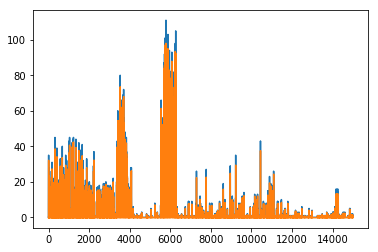

In [28]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 6, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[idx:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[idx:])
pyplot.plot(predictions)
pyplot.show()